# Assignment 2 Part 2: Neural Texture Compression

In this part 2 of of the Assignment 2 we are going to use a neural network to compress a high-resolution texture, from MBs to a few KBs in memory, while retaining its content.

Let's get started!

In [1]:
import slangpy as spy
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import pathlib
from tqdm.notebook import tqdm
from torch.nn import MSELoss
import slangpy_nn as nn
import numpy as np
import torch
from collections import namedtuple

from cs248a_renderer import setup_device


We have defined a new `neural-texture.slang` module in `./shaders`. It contains shaders to render the NeuralTexture that you are going to build.

In [2]:
# Device setup
neural_texture_shader_path = pathlib.Path.cwd() / "shaders"
device = setup_device([neural_texture_shader_path])
neural_texture_module = spy.Module.load_from_file(
    device=device,
    path="neural-texture.slang",
)

## Training a Neural Texture for Low-Resolution Texture map

Before scaling up to high-resolution texture, we'll first demonstrate the building blocks of the NeuralTexture with a Low-resolution texture as it's easier to reason about.

We'll use a 64x128 sized texture image called `pred_tex`, which will be filled by the `render` shader defined in `shaders/neural-texture.slang`.

In [3]:
# Create an image buffer to store the output of your program.
TextureSize = namedtuple('TextureSize', ['height', 'width'])
TEXTURE_SIZE = TextureSize(width=128, height=64)
# output_image is a buffer of OUTPUT_IMG_SIZE[0] x OUTPUT_IMG_SIZE[1] pixels in RGBA format. It is stored in GPU memory.
# Your program is going write to this image buffer.
pred_tex = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=TEXTURE_SIZE.width,
    height=TEXTURE_SIZE.height,
)

### Defining an MLP using `slangpy-nn`
Next, we are going to define the MLP for NeuralTexture. For this purpose, we'll define an MLP natively in Slang using the `slangpy_nn`, that's imported as `nn` here. `nn` provides basic constructs used in deep learning such as linear layers, activations, losses, and optimizers.

You can find this library in the `asst2/external` folder.

#### MLP Architecture
##### Input and Output of MLP
Our MLP takes a 22-dimensional input and returns a 4-dimensional output. The 4 dimensional output represents RGBA channels of a texture map. The 22 dimensional input is composed of 2D UV co-ordinates and the rest of the 20 dimensions are reserved for positional encodings, importance of which we are going to explain a few cells down the line. TL;DR for the curious: It is an augmentation of UV that helps in learning high-frequency signal.

##### Layers and Activations

This MLP is made up of 4 linears layers, each followed by ReLU activations except the last layer which returns the output. Each layer has 64 hidden dimensions (also called width of layer). Feel free to play with these numbers and report its effect on the texture that it learns.

In [4]:
def get_mlp():
    HIDDEN_DIM = 64
    mlp = nn.ModelChain(
        nn.Convert.to_array_kind(nn.ArrayKind.array),
        nn.LinearLayer(num_inputs=nn.Auto, num_outputs=HIDDEN_DIM),
        nn.ReLU(),
        nn.LinearLayer(num_inputs=HIDDEN_DIM, num_outputs=HIDDEN_DIM),
        nn.ReLU(),
        nn.LinearLayer(num_inputs=HIDDEN_DIM, num_outputs=HIDDEN_DIM),
        nn.ReLU(),
        nn.LinearLayer(num_inputs=HIDDEN_DIM, num_outputs=4),
        nn.Convert.to_vector()
    )
    mlp.initialize(module=neural_texture_module, input_type="float[22]")
    return mlp

In [5]:
mlp = get_mlp()

### Getting Ground Truth Texture
We are going to use a texture map of earth. Download texture map of earth from the assignment 2 resources folder: [https://drive.google.com/file/d/1QEmEBgxgpCbX1yvTyZZxsMtx4l_133mU/view?usp=drive_link](https://drive.google.com/file/d/1QEmEBgxgpCbX1yvTyZZxsMtx4l_133mU/view?usp=drive_link) and save it in the `resources` directory. This is a 8K resolution texture map of earth.

We are going to resize it to 64x128 resolution for our use case.

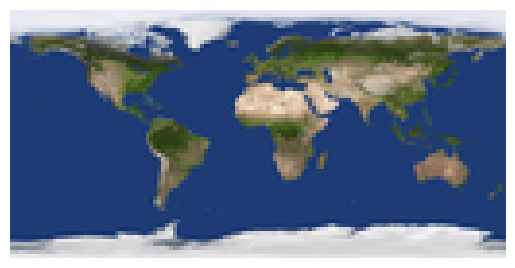

In [6]:
earth_tex = Image.open("../../../resources/earth_8k.jpg").resize(TEXTURE_SIZE[::-1], Image.Resampling.LANCZOS)
earth_tex_np = np.ones((*TEXTURE_SIZE, 4)).astype(np.float32)
earth_tex_np[:, :, :3] = np.clip(np.array(earth_tex)[:, :, :3] / 255.0, 0.0, 1.0)
plt.imshow(earth_tex_np)
plt.axis('off')
plt.show()

In [7]:
gt_tex = device.create_texture(
    width=TEXTURE_SIZE.width,
    height=TEXTURE_SIZE.height,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
    data=earth_tex_np)

### Memory comparison of Texture Map and MLP

Texture size if 0.12 MB as compared to the MLP which is of size of 0.04 MB. That's 3x smaller!

In [8]:
FLOAT_SIZE = 4  # bytes
NUM_CHANNELS = 4
mlp_size = float((np.sum([np.prod(p.shape) for p in mlp.parameters()]) * FLOAT_SIZE) / (2**20))
print(f"MLP size: {mlp_size:.2f} MB")

texture_size = float((np.prod(TEXTURE_SIZE) * FLOAT_SIZE * NUM_CHANNELS) / (2**20))
print(f"Texture size: {texture_size:.2f} MB")


MLP size: 0.04 MB
Texture size: 0.12 MB


We'll get channel-wise mean and std of the texture. They'll be used to unnormalize the NeuralTexture output. Neural networks generally take input and output that's coming from a 0 mean and unit std dev distribution. The same goes for the output. This is done to speed-up the training.

This means that our NeuralTexture is going to give output in 0 mean unit std dev space and in-order to visualize it we'll unnormalize it using these stats.

In [9]:
def getTextureStats(texture_np):
    mu, sigma = texture_np.mean((0, 1)), texture_np.std((0, 1))
    mean = spy.NDBuffer(
        device=device,
        dtype=neural_texture_module.float4.as_struct(),
        shape=(1,),
    )
    mean.copy_from_numpy(mu)
    std = spy.NDBuffer(
        device=device,
        dtype=neural_texture_module.float4.as_struct(),
        shape=(1,),
    )
    std.copy_from_numpy(sigma)
    texture_stats = {
        "mean": mu,
        "std": sigma
    }
    return texture_stats

In [10]:
texture_stats = getTextureStats(earth_tex_np)

Linear Sampler is defined to aid in sampling the texture map. While we are going to make use of it at a later stage of this assignment, we are defning it here because it is required by the `Uniforms` struct (just like the one you had in the `renderer.slang` in the previous assignment tasks). It's functionality is to aid in sampling the texture at arbitrary locations.

In [11]:
linear_sampler = device.create_sampler(
    min_filter=spy.TextureFilteringMode.linear,
    mag_filter=spy.TextureFilteringMode.linear,
    address_u=spy.TextureAddressingMode.clamp_to_edge,
    address_v=spy.TextureAddressingMode.clamp_to_edge,
)


In [12]:
uniforms = {
    "tex": gt_tex,
    "sampler": linear_sampler,
    "usePositionalEncoding": False,
    "stats": texture_stats,
    "canvasSize": np.ascontiguousarray([TEXTURE_SIZE.width, TEXTURE_SIZE.height], dtype=np.uint32)
}

## Training a NeuralTexture
### Forward Pass: Rendering an untrained NeuralTexture
Having defined `mlp` and `unifroms` we are now ready to render your first NeuralTexture! We'll run the `render` shader defined in `./shaders/neural-texture.slang`. Similar to shaders that you've seen earlier since Assignment 1, it takes a pixel location as input, converts it into UV (with the help of `uniforms`) and runs `mlp` on it to get a RGBA color value as output. This color will fill in the corresponding pixel location in `pred_tex` that was defined a few cells back.

Min:  [0.24183169 0.37375432 0.4858105 ] Max:  [0.3489499  0.39953986 0.54323465]


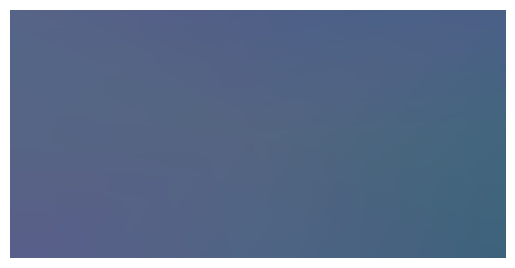

In [13]:
neural_texture_module.render(
    tid=spy.grid(shape=[TEXTURE_SIZE.height, TEXTURE_SIZE.width]),
    mlp=mlp,
    uniforms=uniforms,
    _result=pred_tex
)
# Now, we use matplotlib to display the rendered image in output_image buffer.
pred_tex_np = pred_tex.to_numpy()
im_max = np.max(pred_tex_np[:, :, :3], (0, 1))
im_min = np.min(pred_tex_np[:,:,:3], (0, 1))
print("Min: ", im_min, "Max: ", im_max)
plt.imshow(pred_tex_np)
plt.axis('off')
plt.show()

We get an image close to blue. When we print the range of each channel in the predicted image, we find that it is pretty small (0.03-0.06). This means the MLP output was within a small range which is a result of its weight initialization. The domination of blue color is due to the unnormalization using texture stats, since the blue color is dominating in the earth texture.

### Loss and Gradient computation
To compute the loss, we get the data into PyTorch Tensor format and compute an L2 loss between predicted and ground truth textures. We do this in PyTorch instead of Slang because we want to use `torch.autograd`, which is PyTorch's Automatic Differentiation engine to get gradients. Using this we are going to get $\nabla_{\text{pred\_tex}} \text{loss}$, i.e. gradient of loss (scalar) wrt predicted texture (a tensor).

In [14]:
# Define L2 Loss function
loss_fn = MSELoss()

In [15]:
# Convert predicted and ground truth textures to PyTorch Tensors
pred_tex_pt = torch.from_numpy(pred_tex_np)
pred_tex_pt.requires_grad_(True)
gt_tex_pt = torch.from_numpy(gt_tex.to_numpy())

# Compute loss
loss = loss_fn(pred_tex_pt, gt_tex_pt)
loss

tensor(0.0458, grad_fn=<MseLossBackward0>)

In [16]:
# Compute gradient of loss wrt predicted texture
grad = torch.autograd.grad(loss, pred_tex_pt)

# Print shapes of gradient and predicted texture for verification
print("Gradient shape: ", grad[0].shape)
print("Predicted texture shape: ", pred_tex_pt.shape)

Gradient shape:  torch.Size([64, 128, 4])
Predicted texture shape:  torch.Size([64, 128, 4])


Let's visualize the gradient. We see that the gradient highlights the regions which are in the shape of the texture that we want to learn.

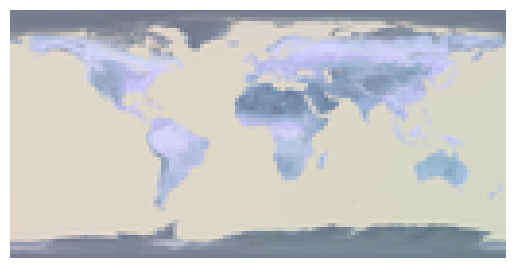

In [17]:
grad_np = grad[0].numpy()

# Min-Max Normalization for visualization
max_grad = np.max(grad_np)
min_grad = np.min(grad_np)
grad_np = (grad_np - min_grad) / (max_grad - min_grad)

plt.imshow(grad_np)
plt.axis('off')
plt.show()


### Backward Pass: Backpropagating throught `slangpy-nn`'s NeuralTexture
Having computed the gradients of predicted texture, we are ready to backpropagate it through NeuralTexture. We are going to do this in Slang. For that, we first need to convert the gradients back to a format that Slang understands: Texture. We create a texture to store the gradients and then call `renderBackward` defined in `./shaders/neural-texture.slang` to backpropagate through the NeuralTexture MLP. `renderBackward` accepts the same inputs as its forward counterpart `render` and additionally takes an extra input of the gradients that we just computed.

In [18]:
grad_tex = device.create_texture(
    width=TEXTURE_SIZE[1],
    height=TEXTURE_SIZE[0],
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
    data=np.array(grad)
)

In [19]:
neural_texture_module.renderBackward(
    tid=spy.grid(shape=[TEXTURE_SIZE.height, TEXTURE_SIZE.width]),
    mlp=mlp,
    uniforms=uniforms,
    dOutput=grad_tex
)

Check if the `mlp`'s parameter's have gradients obtained from backpropagation.

In [20]:
mlp.parameters()[0].grad.to_numpy()

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  1.2158028e-04,  9.0761685e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  1.0903478e-04,  1.9559997e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  1.0168337e-06, -1.2498852e-04],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  3.6364401e-04,  7.3629810e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -1.4779923e-04,  2.4292181e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -5.2140243e-05,  1.7053908e-04]],
      shape=(64, 22), dtype=float32)

### Optimizing NeuralTexture in `slangpy-nn`
`slangpy-nn` has natively implemented `AdamOptimizer` which we going to use to optimizer our `mlp`'s parameters. We get the optimizer `optim` on `mlp`'s parameters and perform an optimization step to update these parameters. A successful optimization step should set the `mlp`'s parameter's gradients to 0.

In [21]:
def get_optim(mlp, lr=1e-1):
    optim = nn.AdamOptimizer(learning_rate=lr)
    optim.initialize(module=neural_texture_module, parameters=mlp.parameters())
    return optim

In [22]:
mlp_abs_grad_sum_before = np.abs(mlp.parameters()[0].grad.to_numpy()).sum()
optim = get_optim(mlp, lr=1e-1)
optim.step()
mlp_abs_grad_sum_after = np.abs(mlp.parameters()[0].grad.to_numpy()).sum()
print(f"Abs Grad sum before optimization step: {mlp_abs_grad_sum_before}")
print(f"Abs Grad sum after optimization step: {mlp_abs_grad_sum_after}")

Abs Grad sum before optimization step: 0.026803532615303993
Abs Grad sum after optimization step: 0.0


### Training a NeuralTexture
We are now ready to train the NeuralTexture. In the following `train` function, we are going to repeat the sequence of above steps for a 1000 times and see the what's learnt.


In [23]:
mlp = get_mlp()
optim = get_optim(mlp, lr=1e-1)

def train(mlp, optim, uniforms, batch_size_height, batch_size_width):
    NUM_TRAIN_STEPS = 1000
    for i in tqdm(range(NUM_TRAIN_STEPS), desc="Training"):
        # Forward pass
        neural_texture_module.render(
            tid=spy.grid(shape=[batch_size_height, batch_size_width]),
            mlp=mlp,
            uniforms=uniforms,
            _result=pred_tex
        )
        pred_tex_pt = torch.from_numpy(pred_tex.to_numpy())
        pred_tex_pt.requires_grad_(True)

        # Loss
        loss = loss_fn(pred_tex_pt, gt_tex_pt)

        # Gradient computation
        grad = torch.autograd.grad(loss, pred_tex_pt)
        grad_tex = device.create_texture(
            width=TEXTURE_SIZE[1],
            height=TEXTURE_SIZE[0],
            format=spy.Format.rgba32_float,
            usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
            data=np.array(grad)
        )

        # Backward pass
        neural_texture_module.renderBackward(
            tid=spy.grid(shape=TEXTURE_SIZE),
            mlp=mlp,
            uniforms=uniforms,
            dOutput=grad_tex
        )

        # Update parameters
        optim.step()

        if i % 100 == 0:
            tqdm.write(f"Iteration {i}, Loss: {loss}")

train(mlp, optim, uniforms, 64, 128)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, Loss: 0.04506003111600876
Iteration 100, Loss: 0.015132294036448002
Iteration 200, Loss: 0.017186254262924194
Iteration 300, Loss: 0.010814730077981949
Iteration 400, Loss: 0.008314289152622223
Iteration 500, Loss: 0.009407746605575085
Iteration 600, Loss: 0.00730917090550065
Iteration 700, Loss: 0.00666891410946846
Iteration 800, Loss: 0.0064672911539673805
Iteration 900, Loss: 0.005927615333348513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010474495..1.0301495].


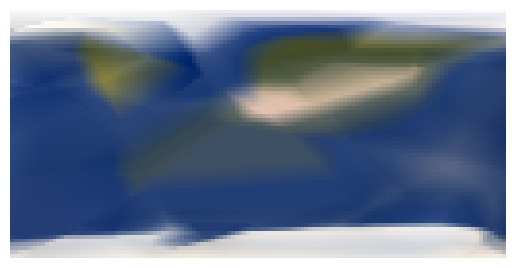

In [24]:
neural_texture_module.render(
        tid=spy.grid(shape=TEXTURE_SIZE),
        mlp=mlp,
        uniforms=uniforms,
        _result=pred_tex
    )

pred_tex_np = pred_tex.to_numpy()
plt.imshow(pred_tex_np)
plt.axis('off')
plt.show()

We see that the NeuralTexture has only learnt low-frequency details, such as blue color of the ocean which is predominant in the earth texture. There are vague hints of landmass being learnt. That gives rise to the question, how might we make the NeuralTexture learn higher-frequency details?

## Positional Encodings

Positional Encodings are used to map low-dimensional input coordinates into a higher-dimensional space, enabling the network to represent high-frequency functions more effectively. In the context of a NeuralTexture, standard $(u, v)$ coordinates are often too "smooth" for an MLP to extract fine-grained detail. By applying a periodic transformation, for e.g. a series of sine and cosine functions at different frequencies, we provide the model with "signals" that fluctuate much more rapidly. 

Instead of passing a coordinate $u$ directly into the network, we apply a mapping $\gamma(u)$:$$\gamma(u) = (\sin(2^0\pi u), \cos(2^0\pi u), ..., \sin(2^{L-1}\pi u), \cos(2^{L-1}\pi u))$$where $L$ determines the number of frequency levels. We set $L=5$ in our implementation.

Without encoding, the network acts as a low-pass filter, resulting in the "vague hints" of landmass you observed. Higher frequencies in the encoding allow the network to become sensitive to the smaller changes in the input space, leading to sharp edges and high-contrast textures.

Go ahead and implement function `getPositionalEncoding` in `./shaders/neural-texture.slang`. Upon a successful implementation, yuo should be able to recover higher-frequency details in the earth texture like shown below:

![nt_128](../../../assets/nt_128.png)

In [25]:
uniforms["usePositionalEncoding"] = True
mlp = get_mlp()
optim = get_optim(mlp, lr=1e-1)
train(mlp, optim, uniforms, 64, 128)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, Loss: 0.04585383087396622
Iteration 100, Loss: 0.007610307540744543
Iteration 200, Loss: 0.005058474838733673
Iteration 300, Loss: 0.0038422602228820324
Iteration 400, Loss: 0.003022385062649846
Iteration 500, Loss: 0.002583106979727745
Iteration 600, Loss: 0.002235732041299343
Iteration 700, Loss: 0.001900985836982727
Iteration 800, Loss: 0.0020608874037861824
Iteration 900, Loss: 0.0018869721097871661


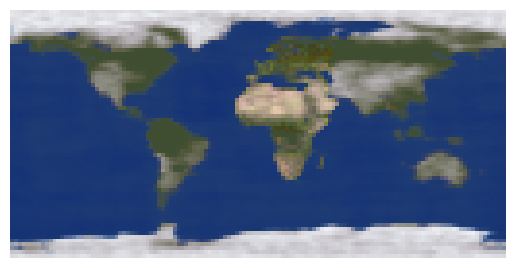

In [26]:
neural_texture_module.render(
        tid=spy.grid(shape=TEXTURE_SIZE),
        mlp=mlp,
        uniforms=uniforms,
        _result=pred_tex
    )
pred_tex_np = pred_tex.to_numpy()
plt.imshow(pred_tex_np)
plt.axis('off')
plt.show()

## Training on High Resolution Texture

### Preparing for training by sampling texture at random locations

So far we have train NeuralTexture on a grid of integral pixel locations of the texture image. These amounted to training batch size of 8k (64*128). But when we increase the resolution of the texture, let's say to 256x512, we have to deal with a batch size of more than 100k. Larger batch size slows down the training or in some cases tests the limits of memory management of slang. Hence, when dealing with textures of high resolution we randomly sample a batch of 64x128 points on the texture image to train with. 

Below we've implemented a version of training code that you saw above but with randomly sampled texture locations to train on, instead of uniform grid.

Let's run it on the existing Low-resolution texture first to ensure that it gets me the same NeuralTexture image that you just obtained after training.

In [27]:
def get_inp_px_locs(batch_size_height, batch_size_width, canvas_height, canvas_width):
    inp_uv_np = np.meshgrid(np.random.rand(batch_size_width), np.random.rand(batch_size_height))
    inp_uv_np = np.stack(inp_uv_np, axis=-1).astype(np.float32)
    inp_uv_np = np.ascontiguousarray(inp_uv_np)
    inp_uv = spy.NDBuffer(
        device=device,
        dtype=neural_texture_module.float2,
        shape=(inp_uv_np.shape[0],inp_uv_np.shape[1]),
    )
    inp_uv.copy_from_numpy(inp_uv_np)

    inp_px_locs_np = inp_uv_np * np.array([canvas_width, canvas_height], dtype=np.float32) - 0.5
    inp_px_locs = spy.NDBuffer(
        device=device,
        dtype=neural_texture_module.float2,
        shape=(inp_px_locs_np.shape[0],inp_px_locs_np.shape[1]),
    )
    inp_px_locs.copy_from_numpy(inp_px_locs_np)
    return inp_uv, inp_px_locs

def train_with_sampling(mlp, optim, uniforms, batch_size_height, batch_size_width):
    NUM_TRAIN_STEPS = 1000
    SEED = 42
    np.random.seed(SEED)
    gt_sampled_tex = device.create_texture(
        width=batch_size_width,
        height=batch_size_height,
        format=spy.Format.rgba32_float,
        usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
    )
    canvas_width, canvas_height = uniforms["canvasSize"]
    for i in tqdm(range(NUM_TRAIN_STEPS), desc="Training"):
        # Sample arbitrary input uv/pixel locations using meshgrid
        inp_uv, inp_px_locs = get_inp_px_locs(batch_size_height, batch_size_width, \
                                              canvas_height, canvas_width)

        # GT Texture at sampled locations, using the sampler.
        neural_texture_module.sample_texture(
            uv=inp_uv,
            uniforms=uniforms,
            _result=gt_sampled_tex
        )

        # Forward pass
        neural_texture_module.renderFloat(
            tid=inp_px_locs,
            mlp=mlp,
            uniforms=uniforms,
            _result=pred_tex
        )
        pred_tex_pt = torch.from_numpy(pred_tex.to_numpy())
        pred_tex_pt.requires_grad_(True)
        gt_sampled_tex_pt = torch.from_numpy(gt_sampled_tex.to_numpy())


        # Loss with the sampled GT texture.
        loss = loss_fn(pred_tex_pt, gt_sampled_tex_pt)

        # Gradient computation
        grad = torch.autograd.grad(loss, pred_tex_pt)
        grad_tex = device.create_texture(
            width=TEXTURE_SIZE[1],
            height=TEXTURE_SIZE[0],
            format=spy.Format.rgba32_float,
            usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
            data=np.array(grad)
        )

        # Backward pass
        neural_texture_module.renderBackwardFloat(
            tid=inp_px_locs,
            mlp=mlp,
            uniforms=uniforms,
            dOutput=grad_tex
        )

        # Update parameters
        optim.step()

        if i % 100 == 0:
            tqdm.write(f"Iteration {i}, Loss: {loss}")            

In [28]:
mlp = get_mlp()
optim = get_optim(mlp, lr=1e-1)
train_with_sampling(mlp, optim, uniforms, 64, 128)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, Loss: 0.04779098182916641
Iteration 100, Loss: 0.004746922291815281
Iteration 200, Loss: 0.0036978605203330517
Iteration 300, Loss: 0.002416344592347741
Iteration 400, Loss: 0.001666885451413691
Iteration 500, Loss: 0.0025384905748069286
Iteration 600, Loss: 0.0016596720088273287
Iteration 700, Loss: 0.001804079976864159
Iteration 800, Loss: 0.0016684536822140217
Iteration 900, Loss: 0.001640688395127654


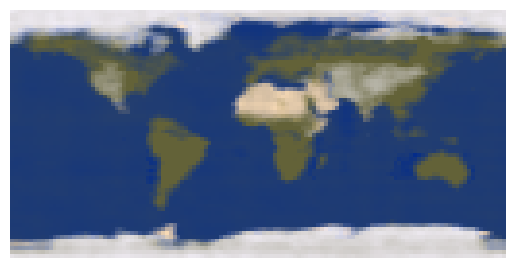

In [29]:
neural_texture_module.render(
        tid=spy.grid(shape=[TEXTURE_SIZE.height, TEXTURE_SIZE.width]),
        mlp=mlp,
        uniforms=uniforms,
        _result=pred_tex
    )

pred_tex_np = pred_tex.to_numpy()
plt.imshow(pred_tex_np)
plt.axis('off')
plt.show()

### Training on High-resolution Texture
Having ensured that training NeuralTexture on randomly sampled texture locations can reproduce our previous results, we are now ready to train on a high-resolution texture. Below, we load the a texture of size 256x512 which is 4x larger than what we had trained previously

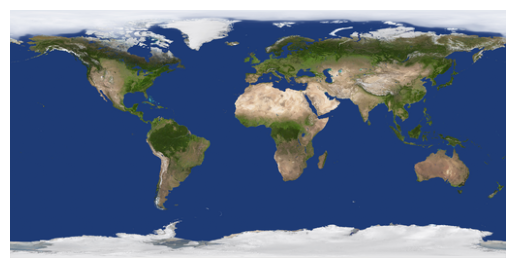

In [30]:
TEXTURE_SIZE_HR = TextureSize(width=512, height=256)
earth_tex_hr = Image.open("../../../resources/earth_8k.jpg").resize([TEXTURE_SIZE_HR.width, TEXTURE_SIZE_HR.height], Image.Resampling.LANCZOS)
earth_tex_hr_np = np.ones((*TEXTURE_SIZE_HR, 4)).astype(np.float32)
earth_tex_hr_np[:, :, :3] = np.clip(np.array(earth_tex_hr)[:, :, :3] / 255.0, 0.0, 1.0)
plt.imshow(earth_tex_hr_np)
plt.axis('off')
plt.show()

#### Compression Ratio
To compare the sizes of NeuralTexture and the High-resolution texture, NeuralTexture is 50x smaller than the high-resolution texture!

In [31]:
NUM_CHANNELS = 4
texture_size_hr = float((np.prod(TEXTURE_SIZE_HR) * NUM_CHANNELS * FLOAT_SIZE) / (2**20))
print(f"MLP size: {mlp_size:.2f} MB")
print(f"Texture size: {texture_size_hr:.2f} MB")

MLP size: 0.04 MB
Texture size: 2.00 MB


In [32]:
gt_tex_hr = device.create_texture(
    width=TEXTURE_SIZE_HR.width,
    height=TEXTURE_SIZE_HR.height,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
    data=earth_tex_hr_np
)

In [33]:
uniforms = {
    "tex": gt_tex_hr,
    "usePositionalEncoding": True,
    "sampler": linear_sampler,
    "stats": getTextureStats(earth_tex_hr_np),
    "canvasSize": np.ascontiguousarray([TEXTURE_SIZE_HR.width, TEXTURE_SIZE_HR.height], dtype=np.uint32)
}

In [34]:
mlp = get_mlp()
optim = get_optim(mlp, lr=1e-1)
train_with_sampling(mlp, optim, uniforms, 64, 128)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, Loss: 0.05083240568637848
Iteration 100, Loss: 0.006321080960333347
Iteration 200, Loss: 0.007029000204056501
Iteration 300, Loss: 0.004783752840012312
Iteration 400, Loss: 0.004365137312561274
Iteration 500, Loss: 0.004538478795439005
Iteration 600, Loss: 0.004226959776133299
Iteration 700, Loss: 0.0055526127107441425
Iteration 800, Loss: 0.0032344097271561623
Iteration 900, Loss: 0.0027632119599729776


In [35]:
pred_tex_hr = device.create_texture(
    width=TEXTURE_SIZE_HR.width,
    height=TEXTURE_SIZE_HR.height,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
)


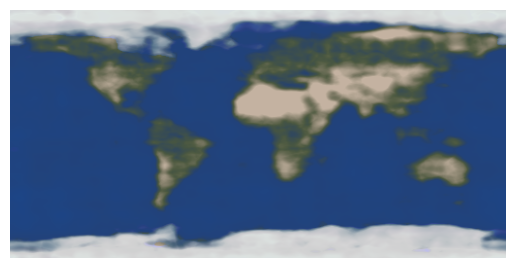

In [36]:
neural_texture_module.render(
    tid=spy.grid(shape=[TEXTURE_SIZE_HR.height, TEXTURE_SIZE_HR.width]),
    mlp=mlp,
    uniforms=uniforms,
    _result=pred_tex_hr
)
plt.imshow(pred_tex_hr.to_numpy())
plt.axis('off')
plt.show()


To check the quality of the learnt texture, we copmute it's Peak Signal-to-Noise Ratio. It is a common metric in computer graphics to measuring the quality of reconstructed or compressed images compared to the original. Higher PSNR means a better quality.

In [37]:
def psnr(pred_tex_hr, gt_tex_hr):
    return 10 * np.log10(1 / np.mean((pred_tex_hr - gt_tex_hr) ** 2))

In [38]:
psnr(pred_tex_hr.to_numpy(), gt_tex_hr.to_numpy())

np.float32(23.467894)

Neural Texture compresses the texture image at just 2% of the memory while having a PSNR of nearly 23.0 which is a decent value given the memory consumption of neural network.

Our implementation could be made more powerful by having more sinusoidal frequencies, a deeper architecture, and skip-connections. You are welcome to explore these tricks to obtain a better PSNR. We encourage you to discuss your implementations with us during Office Hours.